# Project 5: Ensemble Learning on NYC Taxi Trip Dataset

#### You are provided with the NYC Taxi Trip Dataset. This dataset contains information about the taxi trips that took place in different parts of New York City and how much time did that trip take to complete.

#### In this project, the following are the tasks you have to complete:
1. Build a K-Nearest neighbours model for the given dataset and find the best value of K.
2. Build a Linear model for the given dataset with regularisation.
3. Build a Random Forest model for the given dataset.
4. Build a Gradient Boosting model for the given dataset.
5. Combine all the models above using the averaging technique to generate the final predictions.

In [1]:
#Importing the initial required libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [2]:
data = pd.read_csv('nyc_taxi_trip_duration Dataset.csv')

In [3]:
data.shape

(729322, 11)

In [4]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [5]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [6]:
#Checking if there is any null values
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [7]:
data.nunique()

id                    729322
vendor_id                  2
pickup_datetime       709359
dropoff_datetime      709308
passenger_count            9
pickup_longitude       19729
pickup_latitude        39776
dropoff_longitude      27892
dropoff_latitude       53579
store_and_fwd_flag         2
trip_duration           6296
dtype: int64

#### 'id' column is not needed as it contains all unique values

In [8]:
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [9]:
# Using label_encoder to convert object to numerical data type

label_encoder = LabelEncoder()

data['store_and_fwd_flag_encoded']= label_encoder.fit_transform(data['store_and_fwd_flag'])
data['store_and_fwd_flag_encoded']= label_encoder.fit_transform(data['store_and_fwd_flag'])

In [10]:
# converting strings to datetime features
data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)
data['dropoff_datetime'] = pd.to_datetime(data.dropoff_datetime)

In [11]:
# Checking if it is converted to datatime format
data.dtypes

id                                    object
vendor_id                              int64
pickup_datetime               datetime64[ns]
dropoff_datetime              datetime64[ns]
passenger_count                        int64
pickup_longitude                     float64
pickup_latitude                      float64
dropoff_longitude                    float64
dropoff_latitude                     float64
store_and_fwd_flag                    object
trip_duration                          int64
store_and_fwd_flag_encoded             int32
dtype: object

In [12]:
# extracting more features from the pickup_datetime variable
data['pickup_day'] = data['pickup_datetime'].dt.day
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday

In [13]:
# extracting more features from the dropoff_datetime variable
data['dropoff_day'] = data['dropoff_datetime'].dt.day
data['dropoff_hour'] = data['dropoff_datetime'].dt.hour
data['dropoff_weekday'] = data['dropoff_datetime'].dt.weekday

In [14]:
# Now, we'll work on latitude & longitude features
# We can use haversine or geopy to get distance from the given coordinates
from geopy.distance import great_circle

In [15]:
def calc_distance(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
 
 start_coords = (pickup_lat, pickup_long)
 stop_coords = (dropoff_lat, dropoff_long)
 
 return great_circle(start_coords,stop_coords).km

In [16]:
data['distance'] = data.apply(lambda x: calc_distance(x['pickup_latitude'], 
                                                       x['pickup_longitude'],
                                                       x['dropoff_latitude'],
                                                       x['dropoff_longitude']), axis=1)

In [17]:
# feature engineering on passenger_count column
data['passenger_count'].value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
0        33
7         1
9         1
Name: passenger_count, dtype: int64

In [18]:
#We can see there are extremely low values with passenger_count 0, 7 and 9. So, we will remove these records.
data = data[data['passenger_count']!=0]
data = data[data['passenger_count']<=6]

In [19]:
data['passenger_count'].value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
Name: passenger_count, dtype: int64

In [20]:
# Calculate trip duration in hour
data['trip_duration'].describe()/3600

count    202.579722
mean       0.264515
std        1.073531
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

In [21]:
#The maximum trip duration is of 538 hours which seems to be an outlier. To help the model make more accurate prediction, 
#we need to log transform this feature.

In [22]:
# Trip duration in hours
data['trip_duration_in_hour'] = data['trip_duration'].apply(lambda x : x/3600)

In [23]:
# Removing outliers considering that trips are not supposed to exceed a day i.e. 24 hrs
data = data[data['trip_duration_in_hour']<=24]

In [24]:
data['trip_duration_log'] = np.log(data['trip_duration'].values + 1)

In [25]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,store_and_fwd_flag_encoded,pickup_day,pickup_hour,pickup_weekday,dropoff_day,dropoff_hour,dropoff_weekday,distance,trip_duration_in_hour,trip_duration_log
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,...,0,29,16,0,29,16,0,1.199074,0.111111,5.993961
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,...,0,11,23,4,11,23,4,4.129117,0.305556,7.003974
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,...,0,21,17,6,21,18,6,7.250763,0.454167,7.400010
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,...,0,5,9,1,5,10,1,2.361101,0.316944,7.040536
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,...,0,17,6,2,17,6,2,4.328540,0.235556,6.744059


In [26]:
# Now, we'll remove extra columns/variables
df = data.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 
                       'trip_duration_in_hour'])

In [27]:
df.head()

,vendor_id,passenger_count,store_and_fwd_flag_encoded,pickup_day,pickup_hour,pickup_weekday,dropoff_day,dropoff_hour,dropoff_weekday,distance,trip_duration_log
0,2,1,0,29,16,0,29,16,0,1.199074,5.993961
1,1,2,0,11,23,4,11,23,4,4.129117,7.003974
2,2,2,0,21,17,6,21,18,6,7.250763,7.400010
3,2,6,0,5,9,1,5,10,1,2.361101,7.040536
4,1,1,0,17,6,2,17,6,2,4.328540,6.744059


In [28]:
df.shape

(729286, 11)

In [29]:
#independent variables
X = df.drop('trip_duration_log', axis=1)

#dependent variable
y = df['trip_duration_log']

## 1. KNN Model 

In [30]:
# First, We'll scale the data:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)

X = pd.DataFrame(x_scaled, columns=X.columns)

In [31]:
X.head()

,vendor_id,passenger_count,store_and_fwd_flag_encoded,pickup_day,pickup_hour,pickup_weekday,dropoff_day,dropoff_hour,dropoff_weekday,distance
0,1.0,0.0,0.0,0.933333,0.695652,0.000000,0.933333,0.695652,0.000000,0.000966
1,0.0,0.2,0.0,0.333333,1.000000,0.666667,0.333333,1.000000,0.666667,0.003327
2,1.0,0.2,0.0,0.666667,0.739130,1.000000,0.666667,0.782609,1.000000,0.005843
3,1.0,1.0,0.0,0.133333,0.391304,0.166667,0.133333,0.434783,0.166667,0.001903
4,0.0,0.0,0.0,0.533333,0.260870,0.333333,0.533333,0.260870,0.333333,0.003488


In [32]:
#importing the train-test split
from sklearn.model_selection import train_test_split

In [33]:
#importing other libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [35]:
#elbow curve to determine the best value of k

In [36]:
def elbow(k):
  test = []

  for i in k:
    reg = KNeighborsRegressor(n_jobs=-1, n_neighbors=i)
    reg.fit(X_train, y_train)

    tmp_pred = reg.predict(X_test)
    temp_error = sqrt(mean_squared_error(tmp_pred, y_test))
    test.append(temp_error)

  return test

In [37]:
k = range(1, 10)

In [38]:
test = elbow(k)

Text(0.5, 1.0, 'Elbow curve for test')

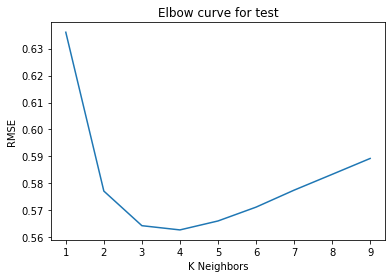

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
# plotting the curve
plt.plot(k, test)
plt.xlabel('K Neighbors')
plt.ylabel('RMSE')
plt.title('Elbow curve for test')

In [40]:
#We're taking n_neighbors=4 as the lowest error occurs at 4 in the above graph:

knnr = KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
knnr.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1, n_neighbors=4)

In [41]:
# Getting prediction
knn_y_pred = knnr.predict(X_test)

# Now, getting RMSE score
score = r2_score(y_test, knn_y_pred)

print("r_square of knn model: ", score)

r_square of knn model:  0.4998377578549731


## 2. Linear model using regularization

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [44]:
# Getting prediction
y_pred = lr.predict(X_test)

# Again getting RMSE score
score = r2_score(y_test, y_pred)
print("r-square of linear regressor model: ", score)

r-square of linear regressor model:  0.36508359775617505


In [57]:
# Create ridge regression model
ridge_regression = Ridge(alpha=0.001)
ridge_regression.fit(X_train, y_train)
######### took the alpha parameter using grid search on a different notebook

Ridge(alpha=0.001)

In [58]:
# Getting prediction
ridge_y_pred = ridge_regression.predict(X_test)

# Again getting RMSE score
score = r2_score(y_test, ridge_y_pred)
print("r-square of ridge regressor model: ", score)

r-square of ridge regressor model:  0.36506765940304153


## 3. Random Forest Model

In [59]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
# Create random forest regression model
clf = RandomForestRegressor(random_state=56)
clf.fit(X_train, y_train)

RandomForestRegressor(random_state=56)

In [70]:
# Using Random search to improve the model performance by selecting best hyperparameters
from sklearn.model_selection import RandomizedSearchCV

In [71]:
para_grid = {
    'max_depth' : [3, 6, 9, 12, 15, 18, 21],
    'n_estimators' : [100, 150, 200, 250, 300, 350]
    }

In [72]:
randomsearch = RandomizedSearchCV(estimator=clf, param_distributions=para_grid, n_iter=5 , cv=3)

In [73]:
randomsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=56),
                   n_iter=5,
                   param_distributions={'max_depth': [3, 6, 9, 12, 15, 18, 21],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350]})

In [75]:
randomsearch.best_params_

{'n_estimators': 350, 'max_depth': 15}

In [76]:
# Putting above best hyperparameters here:
clf = RandomForestRegressor(random_state=56, n_estimators=350, max_depth=15 )
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=350, random_state=56)

In [77]:
# Getting prediction
pred1 = clf.predict(X_test)

# Again, getting RMSE score
score = r2_score(y_test, pred1)
print("r-square of random forest regressor model: ", score)

r-square of random forest regressor model:  0.6906576414763987


Initial score was: 0.6677435123744506.  

After using random search to select hyperparameters, the score improved: 0.6906576414763987

## 4. Gradient Boosting Model

In [66]:
#Importing GBDT Regressor 
from sklearn.ensemble import GradientBoostingRegressor

GradientBoostingRegressor(max_depth=12, n_estimators=200, random_state=56)

In [ ]:
##### Used grid search on a different notebook as system was crashing again & again while applying on this notebook.

dlf = GradientBoostingRegressor(random_state = 56, max_depth =12, n_estimators= 200)
dlf.fit(X_train, y_train)

In [67]:
pred2 = dlf.predict(X_test)

# Again, getting RMSE score
score = r2_score(y_test, pred2)
score

0.7133321290869725



Initial score was: 0.6577938373282

After using grid search to select hyperparameters, the score improved: 0.7133321290869725

## 5. Averaging of the above models

In [80]:
final_pred = (knn_y_pred + ridge_y_pred + pred1 + pred2)/4

score = r2_score(y_test, final_pred)
score

0.6650294761127045

### Average prediction of all models is: 0.6650294761127045